# CONTROL SYSTEMS

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

$\xrightarrow{1} S_1$,
$S_1 \xrightarrow{k_1 S_1} S_2$,
$S_2 \xrightarrow{k_2 S_3} S_3$,
$S_3 \xrightarrow{k_3 S_3} S_2$,
$S_2 \xrightarrow{k_2 S_3} \emptyset$,

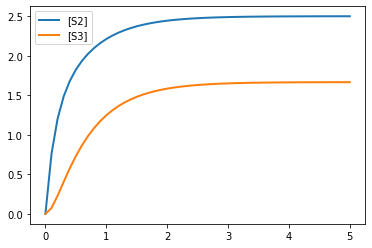

In [3]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
rr = te.loada(MODEL)
rr.simulate()
rr.plot()

We are going to control ``S3`` by changing ``S2``.

In [4]:
ctlsb = ctl.ControlSBML(MODEL,  input_names=["S2"], output_names=["S3"])
tf = ctlsb.makeTransferFunction()
tf

TransferFunction(array([2.]), array([ 1.,  9., 12.]))

In [5]:
sys = ctlsb.makeNonlinearIOSystem("sys")

In [6]:
result = control.input_output_response(sys, TIMES, u=0)
result.outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
ref = [0.4]  # Desired value of S3
def controller_outfcn(_, __, u, ___):
    return 2*(ref[0] - u[0])

In [22]:
controller = control.NonlinearIOSystem(
    None, controller_outfcn, inputs=['in'], outputs=['out'],
    name="controller")

In [23]:
# Create the closed loop system
closed_loop = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.S2', 'controller.out'],
    ['controller.in',  'sys.S3'],
  ],
  inplist=["controller.in"],
  outlist=["sys.S2", "sys.S3"],
)

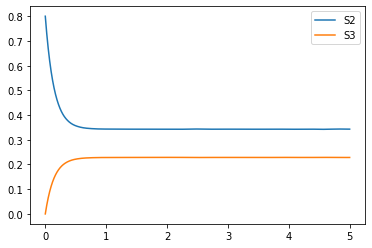

In [24]:
result = control.input_output_response(closed_loop, T=TIMES)
plt.plot(TIMES, result.outputs[0], TIMES, result.outputs[1])
plt.legend(["S2", "S3"])